# Assignment 5 - Arpit Srivastava

## Importing required libraries and cleaning data

In [151]:
import numpy as np
import re
import pandas as pd
import nltk.tokenize
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
import gensim
from gensim.models import Word2Vec
from gensim.models.fasttext import FastText
from gensim.models import Doc2Vec
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import AffinityPropagation
from sklearn.manifold import MDS
from sklearn.metrics.pairwise import cosine_similarity
import scipy.cluster.hierarchy as sch
wordnet = nltk.stem.WordNetLemmatizer()
stop_words = nltk.corpus.stopwords.words('english')

In [2]:
df=pd.read_csv("C:\\Users\\arpit\\Downloads\\News_SocialMedia(1).csv")
df=df[['Title', 'Headline','Topic']]
df['Title']=[str(i) for i in df.Title]
df['Topic']=[str(i) for i in df.Topic]
df.dropna(inplace=True)
df.reset_index(drop=True,inplace=True)

In [3]:
df.shape

(93224, 3)

In [4]:
#Cleaning
headline=[]
for i in range(len(df.Headline)):
    s=df.Headline[i]
    for char in s:
        if char in '!#$%&@?,.:;+-*/=<>"\'()[\\]X{|}~\n\t':
            s = s.replace(char, ' ')
            s=re.sub(r'http\S+', ' ', s)
    x=[w for w in nltk.tokenize.word_tokenize(s.lower()) if w not in stop_words and len(w)>2]
    lemm = [wordnet.lemmatize(w) for w in x]
    headline.append(" ".join(lemm))
df['headline_clean']=headline
df.head()

,Title,Headline,Topic,headline_clean
0,Obama Lays Wreath at Arlington National Cemetery,Obama Lays Wreath at Arlington National Cemete...,obama,obama lay wreath arlington national cemetery p...
1,A Look at the Health of the Chinese Economy,"Tim Haywood, investment director business-unit...",economy,tim haywood investment director business unit ...
2,Nouriel Roubini: Global Economy Not Back to 2008,"Nouriel Roubini, NYU professor and chairman at...",economy,nouriel roubini nyu professor chairman roubini...
3,Finland GDP Expands In Q4,Finland's economy expanded marginally in the t...,economy,finland economy expanded marginally three mont...
4,"Tourism, govt spending buoys Thai economy in J...",Tourism and public spending continued to boost...,economy,tourism public spending continued boost econom...


In [5]:
#Finding number of unique topics
len(df.Topic.unique())

4

## Feature Engineering

### TFIDF Vectorizer

In [6]:
tfidf_vect_headline = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', 
max_features=10000)
tfidfmatrix=tfidf_vect_headline.fit_transform(list(df['headline_clean']))

In [7]:
tfidfmatrix.shape

(93224, 10000)

In [25]:
tfidfmatrix

<93224x10000 sparse matrix of type '<class 'numpy.float64'>'
	with 1367377 stored elements in Compressed Sparse Row format>

### doc2vec

In [8]:
LabeledSentence1 = gensim.models.doc2vec.TaggedDocument
all_content_train = []
j=0
for em in df.headline_clean:
    all_content_train.append(LabeledSentence1(em,[j]))
    j+=1

In [9]:
d2v_model = Doc2Vec(all_content_train, vector_size = 100, window = 10, min_count = 500, workers=7, dm = 1,alpha=0.025, min_alpha=0.001)
d2v_model.train(all_content_train, total_examples=d2v_model.corpus_count, epochs=10, start_alpha=0.002, end_alpha=-0.016)
d2vmatrix=d2v_model.docvecs.doctag_syn0

C:\Users\arpit\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `doctag_syn0` (Attribute will be removed in 4.0.0, use docvecs.vectors_docs instead).
  This is separate from the ipykernel package so we can avoid doing imports until


In [10]:
d2vmatrix.shape

(93224, 100)

### word2vec

In [104]:
w2vmodel = FastText(df.headline_clean,min_count=1)# Empty model, no training
w2vmodel.train(df.headline_clean,total_examples=w2vmodel.corpus_count,epochs=w2vmodel.epochs)
vocab = set(w2vmodel.wv.index2word)

In [105]:
def average_word_vectors(words, model, vocabulary, num_features):
    feature_vector = np.zeros((num_features,), dtype="float64")
    nwords = 0.
    for word in words:
        if word in vocabulary: 
            nwords = nwords + 1.
            feature_vector = np.add(feature_vector, model.wv[word])
    if nwords:
        feature_vector = np.divide(feature_vector, nwords)
    return feature_vector

In [106]:
train_features = [average_word_vectors(x, w2vmodel, vocab, 
    100) for x in df.headline_clean]
w2vmatrix = np.array(train_features)

In [107]:
w2vmatrix.shape

(93224, 100)

### Clustering Functions

In [134]:
def elbowplot(matrix):
    N = range(1, 7)
    kmeans = [KMeans(n_clusters=i) for i in N]
    score = [kmeans[i].fit(matrix).score(matrix) for i in range(len(kmeans))]
    plt.plot(N, score)
    plt.xlabel('Number of Clusters')
    plt.ylabel('Score')
    plt.title('Elbow Curve')
    plt.show()

def kmeans(n_clusters,matrix):
    km = KMeans(n_clusters=n_clusters)
    km.fit(d2v_model.docvecs.doctag_syn0)
    labels = km.labels_
    clusters = labels.tolist()
    order_centroids = km.cluster_centers_.argsort()[:, ::-1]
    return clusters

def agglomerative(n_clusters,matrix):
    agg= AgglomerativeClustering(n_clusters=n_clusters)
    clusters = agg.fit(matrix)
    labels=clusters.labels_
    clusters= labels.tolist()
    return clusters
    
    
def mdsplot(title, matrix, n_clusters, clusters):
    distance = 1 - cosine_similarity(matrix)  
    mds = MDS(n_components=2, dissimilarity="precomputed", random_state=42)
    pos = mds.fit_transform(distance)
    xs, ys = pos[:, 0], pos[:, 1]
    # Set up cluster names using a dict
    if n_clusters==4:
        cluster_names = {0: 'Cluster 1', 1: 'Cluster 2', 2: 'Cluster 3', 
                         3: 'Cluster 4'}
        cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 
                          3: '#e7298a'}
    elif n_clusters==3:
        cluster_names = {0: 'Cluster 1', 1: 'Cluster 2', 2: 'Cluster 3'}
        cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3'}
    elif n_clusters==2:
        cluster_names = {0: 'Cluster 1', 1: 'Cluster 2'}
        cluster_colors = {0: '#1b9e77', 1: '#d95f02'}
    # Plot clusters
    df1 = pd.DataFrame(dict(x=xs, y=ys, label=clusters)) 
    groups = df1.groupby('label')
    fig, ax = plt.subplots(figsize=(17, 9))
    plt.title(title)
    for name, group in groups:
        ax.plot(group.x, group.y, marker='o', linestyle='',alpha=0.5, ms=20, 
            label=cluster_names[name], color=cluster_colors[name], mec='none')
        ax.set_aspect('auto')
        ax.tick_params(axis= 'x',  which='both', bottom='off', top='off', 
    labelbottom='off')
        ax.tick_params(axis= 'y', which='both', left='off', top='off', labelleft='off')
    ax.legend(numpoints=1) 
    plt.show()

def ward_hierarchical_clustering(feature_matrix):
    
    cosine_distance = 1 - cosine_similarity(feature_matrix)
    linkage_matrix = sch.ward(cosine_distance)
    return linkage_matrix 

def plot_hierarchical_clusters(linkage_matrix, data):
    # set size
    fig, ax = plt.subplots(figsize=(15,15)) 
    titles = data.tolist()
    # plot dendrogram
    ax = sch.dendrogram(linkage_matrix, labels=None)
    plt.tick_params(axis= 'x',   
                    which='both',  
                    bottom='off',
                    top='off',
                    labelbottom='off')
    plt.tight_layout()
    plt.show()

## Memory error

In [ ]:
agglabels=agglomerative(4,tfidfmatrix)

## Solution

Because of memory error, I have decided to use only top 2000 rows from the dataframe.

## Data preparation

In [16]:
dfsmall=df.head(2000)
dfsmall.shape

(2000, 4)

In [108]:
tfidfsmall=tfidfmatrix[:2000]
d2vmatrixsmall=d2vmatrix[:2000]
w2vmatrixsmall=w2vmatrix[:2000]

In [109]:
tfidfsmall

<2000x10000 sparse matrix of type '<class 'numpy.float64'>'
	with 30841 stored elements in Compressed Sparse Row format>

## K-means Clustering using tfidf

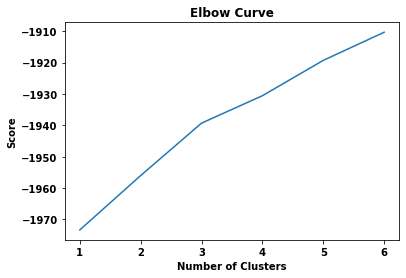

In [52]:
elbowplot(tfidfsmall)

Looking at the elbow plot, the ideal number of clusters should be 3

In [33]:
dfsmall['Kclusters_tfidf']=kmeans(3,tfidfsmall)[:2000]
dfsmall.head()

C:\Users\arpit\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning: Call to deprecated `doctag_syn0` (Attribute will be removed in 4.0.0, use docvecs.vectors_docs instead).
  
C:\Users\arpit\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Title,Headline,Topic,headline_clean,Kclusters_tfidf
0,Obama Lays Wreath at Arlington National Cemetery,Obama Lays Wreath at Arlington National Cemete...,obama,obama lay wreath arlington national cemetery p...,1
1,A Look at the Health of the Chinese Economy,"Tim Haywood, investment director business-unit...",economy,tim haywood investment director business unit ...,2
2,Nouriel Roubini: Global Economy Not Back to 2008,"Nouriel Roubini, NYU professor and chairman at...",economy,nouriel roubini nyu professor chairman roubini...,2
3,Finland GDP Expands In Q4,Finland's economy expanded marginally in the t...,economy,finland economy expanded marginally three mont...,2
4,"Tourism, govt spending buoys Thai economy in J...",Tourism and public spending continued to boost...,economy,tourism public spending continued boost econom...,2


In [34]:
dfsmall.Kclusters_tfidf.value_counts().sort_index()

0    304
1    741
2    955
Name: Kclusters_tfidf, dtype: int64

## Agglomerative clustering using tfidf

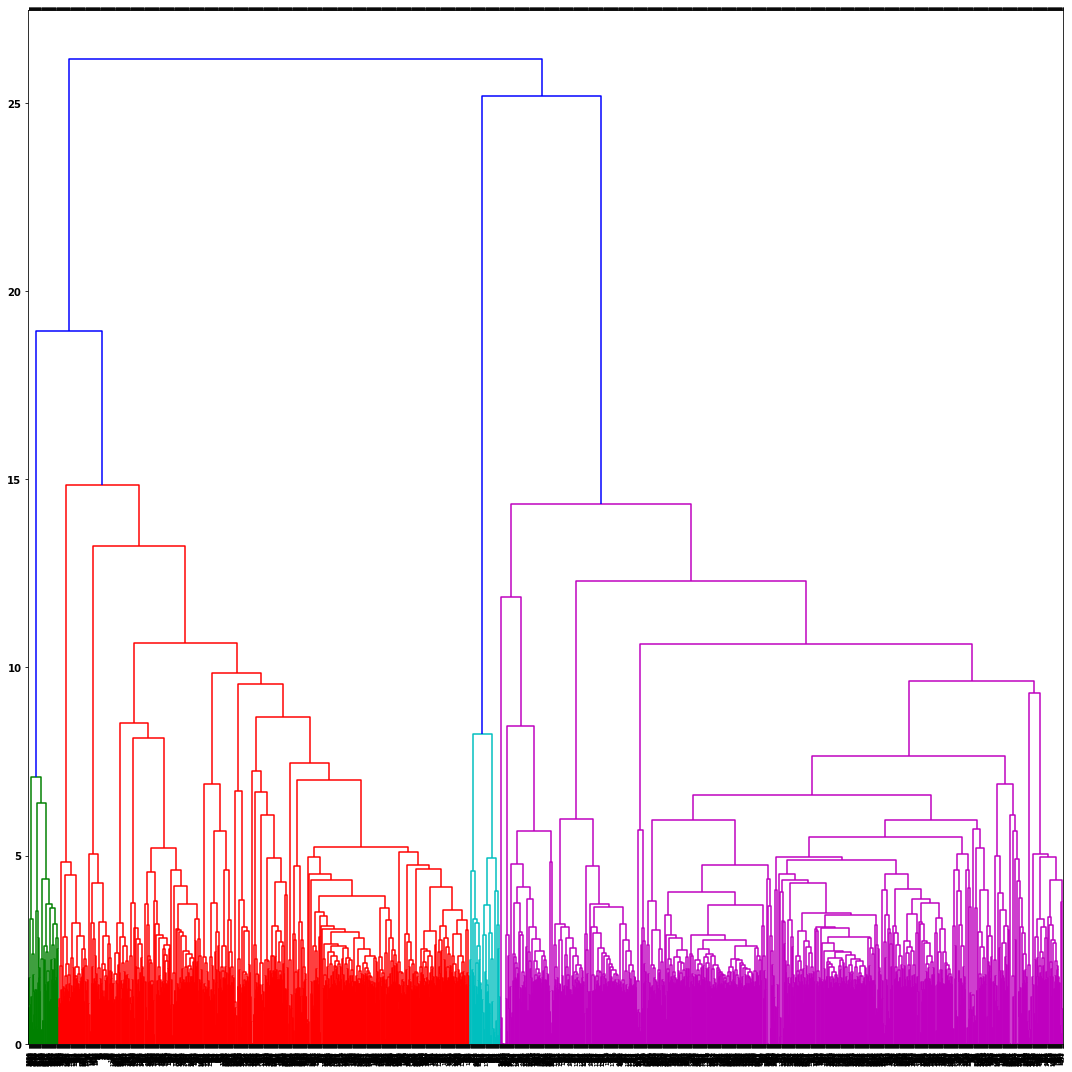

In [78]:
plot_hierarchical_clusters(ward_hierarchical_clustering(tfidfsmall),dfsmall.headline_clean)

Given that the highest vertical slot that does not intersect with any clusters lies between 15 and 18. Only 4 lines cross the threshold of 18. That means 4 is the ideal number of clusters.

In [93]:
agglabels=agglomerative(4,tfidfsmall.toarray())

In [94]:
pd.Series(agglabels).value_counts().sort_index()

0     809
1      76
2    1078
3      37
dtype: int64

In [95]:
dfsmall['Aggclusters_tfidf']=agglabels

C:\Users\arpit\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


## Kmeans using doc2vec

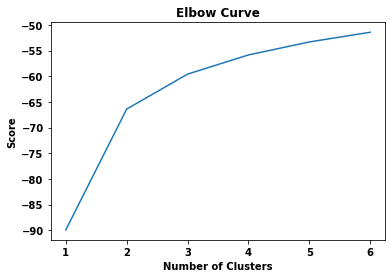

In [40]:
elbowplot(d2vmatrixsmall)

Looking at the elbow plot, the ideal number of clusters should be 2.

In [42]:
dfsmall['Kclusters_d2v']=kmeans(2,d2vmatrixsmall)[:2000]
dfsmall.head()

C:\Users\arpit\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning: Call to deprecated `doctag_syn0` (Attribute will be removed in 4.0.0, use docvecs.vectors_docs instead).
  
C:\Users\arpit\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Title,Headline,Topic,headline_clean,Kclusters_tfidf,Aggclusters_tfidf,Kclusters_d2v
0,Obama Lays Wreath at Arlington National Cemetery,Obama Lays Wreath at Arlington National Cemete...,obama,obama lay wreath arlington national cemetery p...,1,2,1
1,A Look at the Health of the Chinese Economy,"Tim Haywood, investment director business-unit...",economy,tim haywood investment director business unit ...,2,2,0
2,Nouriel Roubini: Global Economy Not Back to 2008,"Nouriel Roubini, NYU professor and chairman at...",economy,nouriel roubini nyu professor chairman roubini...,2,2,1
3,Finland GDP Expands In Q4,Finland's economy expanded marginally in the t...,economy,finland economy expanded marginally three mont...,2,2,0
4,"Tourism, govt spending buoys Thai economy in J...",Tourism and public spending continued to boost...,economy,tourism public spending continued boost econom...,2,2,0


In [43]:
dfsmall.Kclusters_d2v.value_counts().sort_index()

0     774
1    1226
Name: Kclusters_d2v, dtype: int64

## Agglomerative clustering using doc2vec

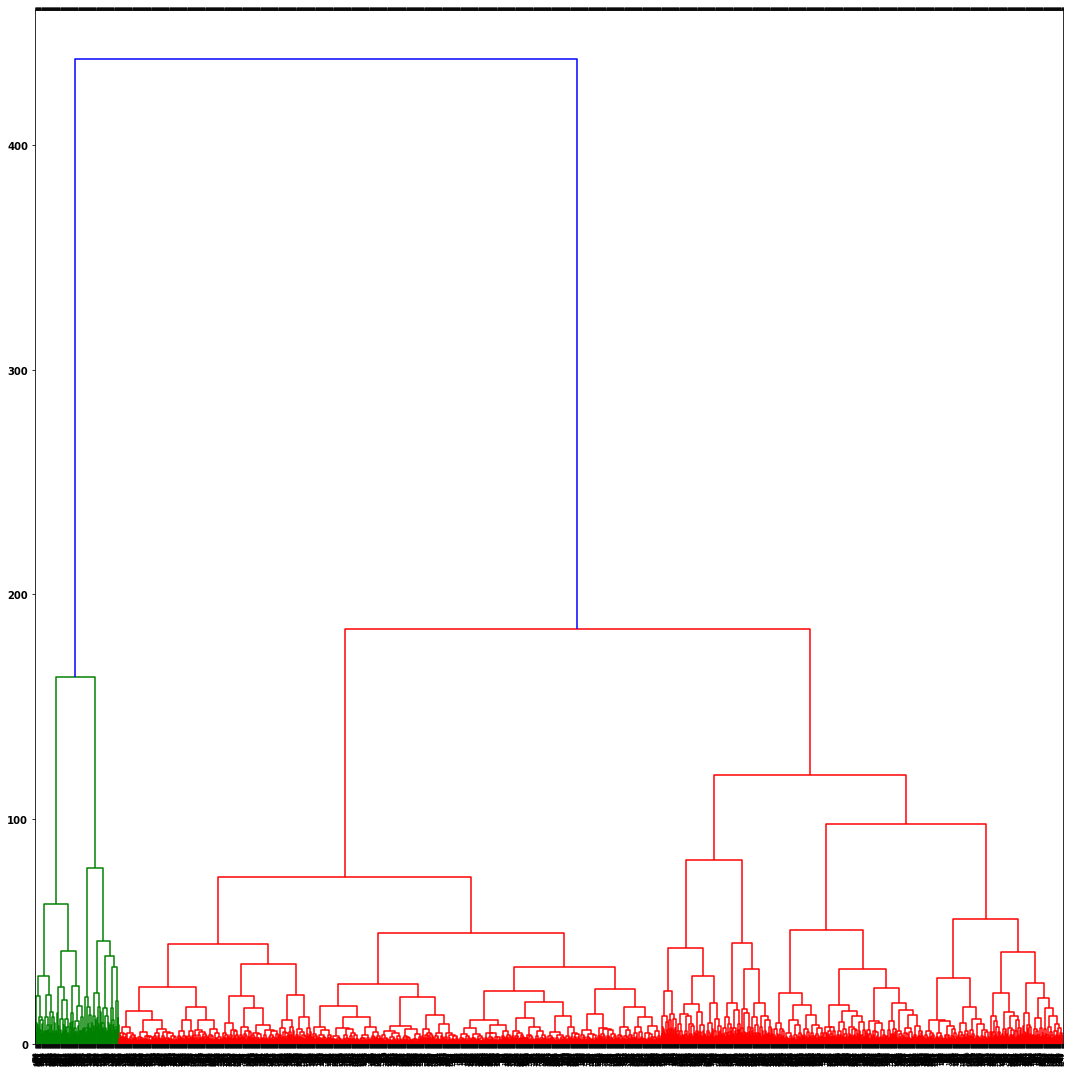

In [79]:
plot_hierarchical_clusters(ward_hierarchical_clustering(d2vmatrixsmall),dfsmall.headline_clean)

Using similar principle as with tfidf matrix, the ideal number of clusters is 4.

In [96]:
dfsmall['Aggclusters_d2v']=agglomerative(4,d2vmatrixsmall)

C:\Users\arpit\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [98]:
dfsmall['Aggclusters_d2v'].value_counts()

1    607
3    582
0    506
2    305
Name: Aggclusters_d2v, dtype: int64

## Kmeans using word2vec (FastText)

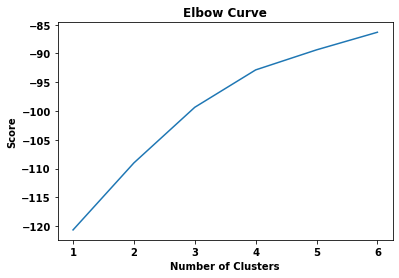

In [110]:
elbowplot(w2vmatrixsmall)

Looking at the elbow plot, the ideal number of clusters should be 4

In [125]:
dfsmall['Kclusters_w2v']=kmeans(4,w2vmatrixsmall)[:2000]

C:\Users\arpit\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `doctag_syn0` (Attribute will be removed in 4.0.0, use docvecs.vectors_docs instead).
  del sys.path[0]
C:\Users\arpit\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [126]:
dfsmall['Kclusters_w2v'].value_counts()

1    735
3    570
0    568
2    127
Name: Kclusters_w2v, dtype: int64

## Agglomerative clustering using word2vec (FastText)

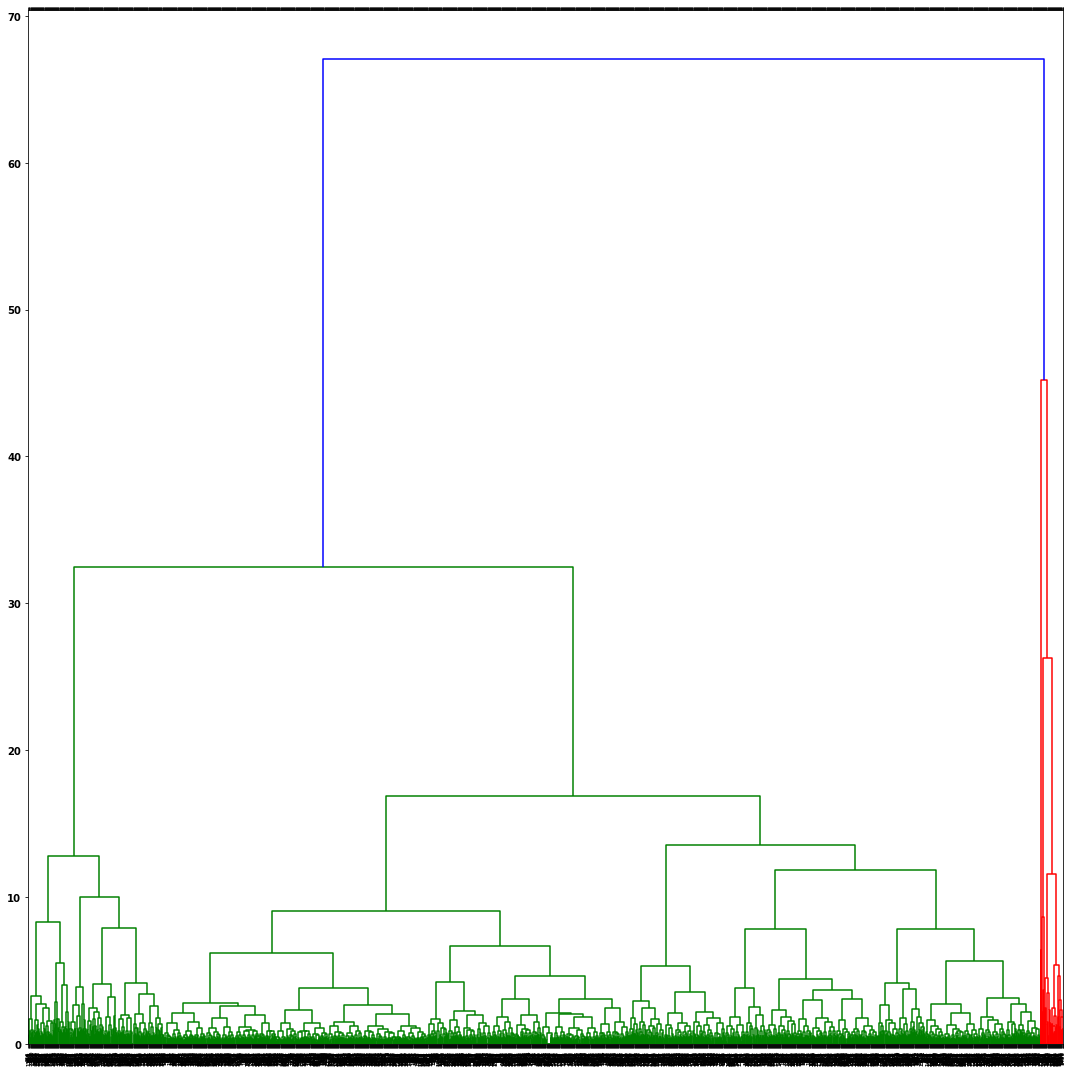

In [112]:
plot_hierarchical_clusters(ward_hierarchical_clustering(w2vmatrixsmall),dfsmall.headline_clean)

The ideal number of clusters are 3

In [115]:
dfsmall['Aggclusters_w2v']=agglomerative(3,w2vmatrixsmall)

C:\Users\arpit\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [129]:
dfsmall.drop('headline_clean',1).to_csv('Assignment 5.csv')

## Evaluation

In [131]:
clusterlist=[['kmeans_tfidf',tfidfsmall,3,dfsmall.Kclusters_tfidf],
            ['Agglomerative_tfidf',tfidfsmall,4,dfsmall.Aggclusters_tfidf],
            ['kmeans_d2v',d2vmatrixsmall,2,dfsmall.Kclusters_d2v],
            ['Agglomerative_d2v',d2vmatrixsmall,4,dfsmall.Aggclusters_d2v],
            ['kmeans_w2v',w2vmatrixsmall,4,dfsmall.Kclusters_w2v],
            ['Agglomerative_w2v',w2vmatrixsmall,3,dfsmall.Aggclusters_w2v]]

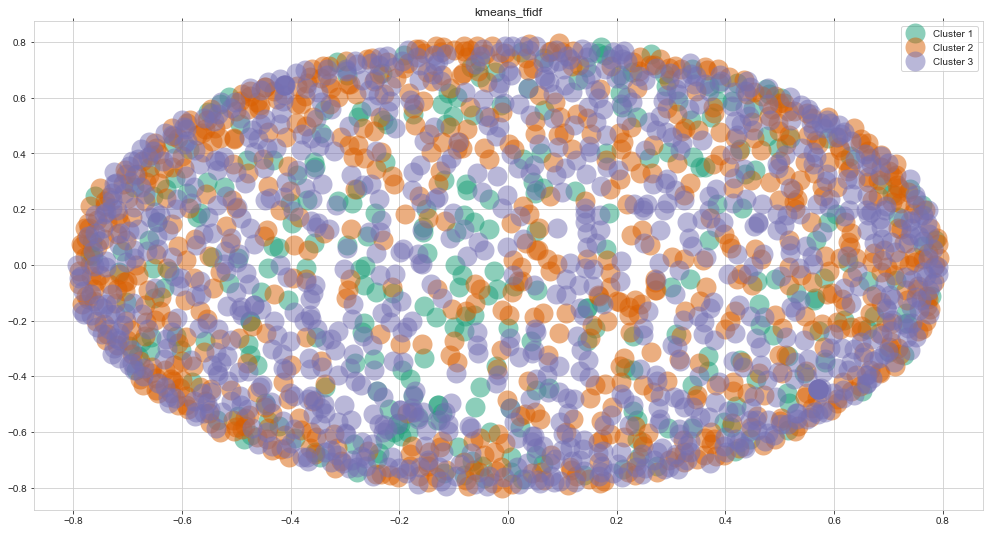

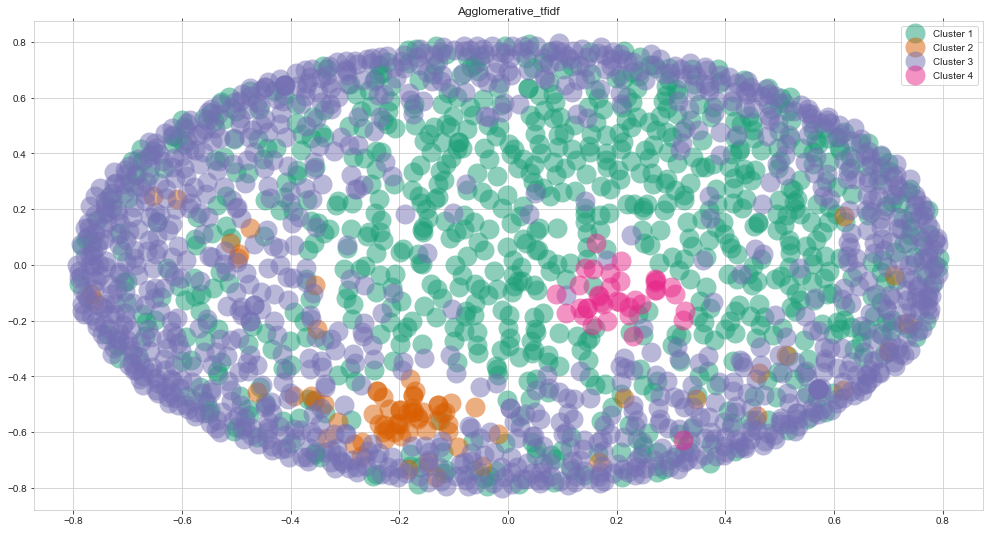

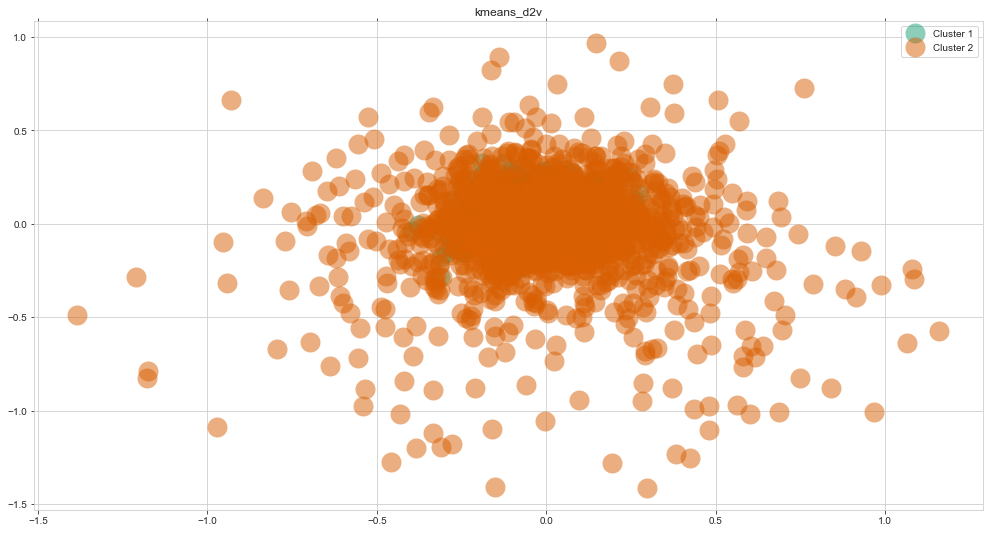

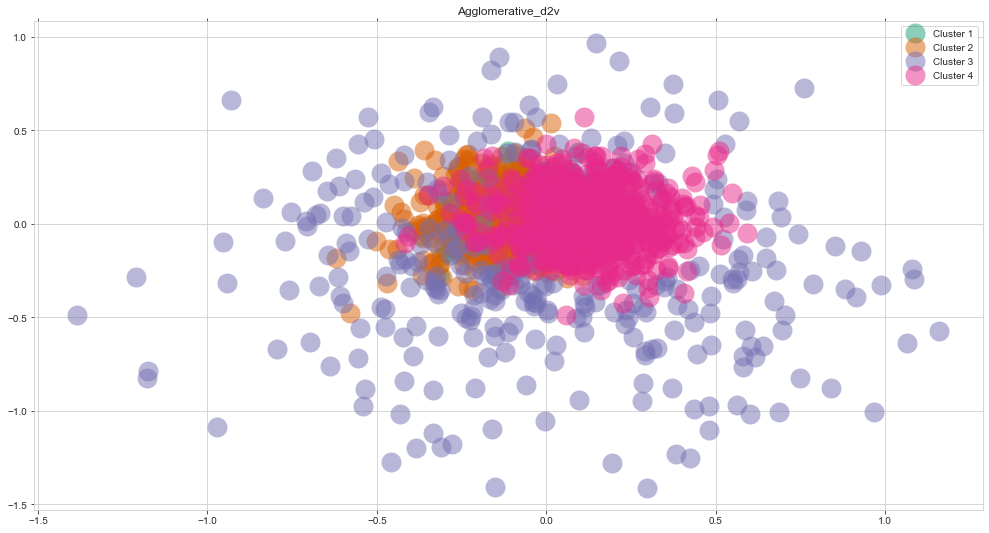

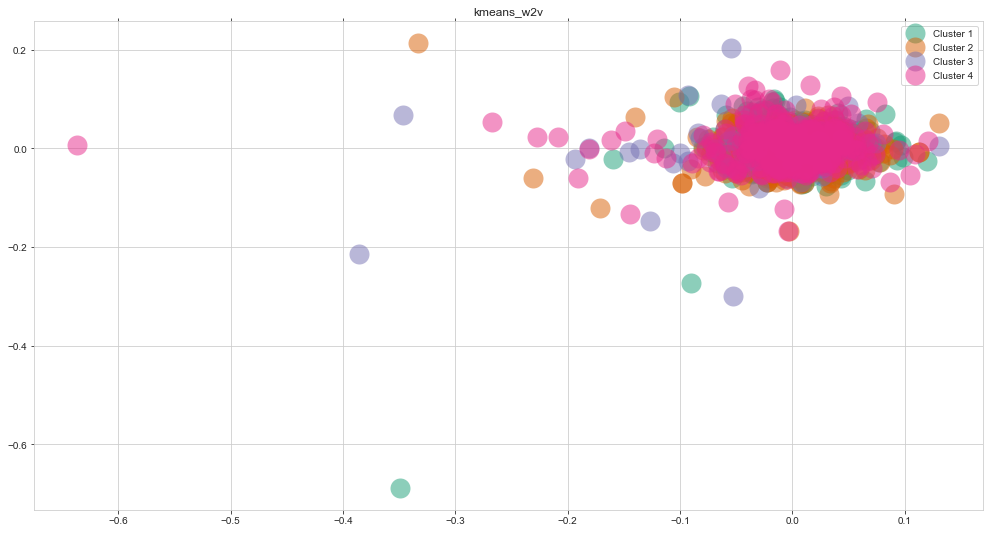

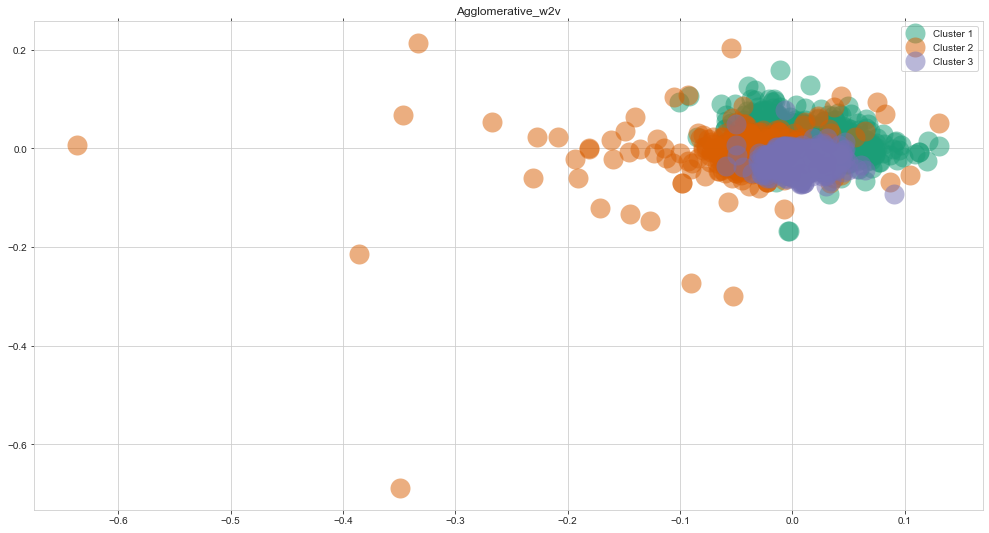

In [150]:
for x in clusterlist:
    mdsplot(x[0],x[1],x[2],x[3])

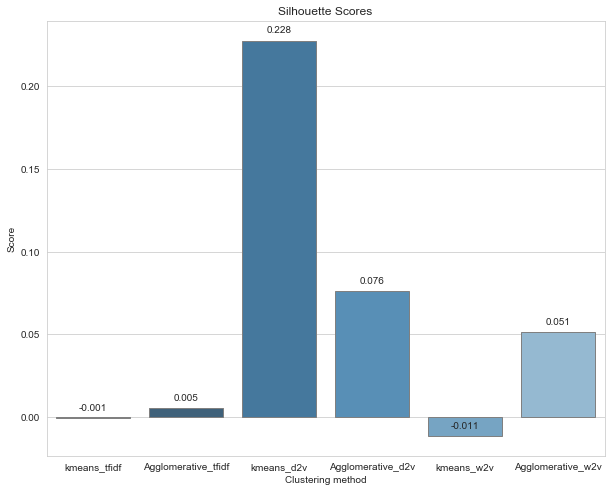

In [145]:
#Silhouette Scores
from sklearn import metrics
plt.figure(figsize=(10,8))
sns.set_style('whitegrid')
splot=sns.barplot(x=[i[0] for i in clusterlist],
                  y=[metrics.silhouette_score(i[1],i[3]) for i in clusterlist],
                  saturation=0.75,edgecolor='grey',
                  palette="Blues_d")
plt.title('Silhouette Scores')
plt.xlabel('Clustering method')
plt.ylabel('Score')
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.3f'),
               (p.get_x() + p.get_width() / 2., p.get_height()), 
               ha = 'center', va = 'center', xytext = (0, 10),
               textcoords = 'offset points')
plt.show()

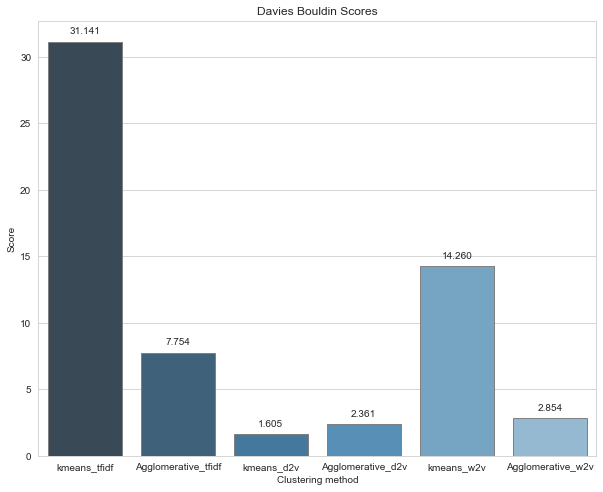

In [149]:
#Davis-Bouldin Index
from sklearn import metrics
plt.figure(figsize=(10,8))
sns.set_style('whitegrid')
splot=sns.barplot(x=[i[0] for i in clusterlist],
                  y=[metrics.davies_bouldin_score(clusterlist[i][1],clusterlist[i][3])\
                     if i not in [0,1] else \
                     metrics.davies_bouldin_score(clusterlist[i][1].toarray(),clusterlist[i][3])\
                     for i in range(len(clusterlist))],
                  saturation=0.75,edgecolor='grey',
                  palette="Blues_d")
plt.title('Davies Bouldin Scores')
plt.xlabel('Clustering method')
plt.ylabel('Score')
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.3f'),
               (p.get_x() + p.get_width() / 2., p.get_height()), 
               ha = 'center', va = 'center', xytext = (0, 10),
               textcoords = 'offset points')
plt.show()

From the Cluster plots above, nothing much is clear. Although, it looks like Kmeans clustering with Doc2vec has the best result. To verify it, I tried two different approaches.

Silhoutte Scores: 

The higher the score the better the model. From the looks of it, kmeans with doc2vec has outperformed every other model by a margin.

Davies Bouldin Score:

The lower the score, the better the model. Also, here kmeans model with doc2vec has outperformed others, other than agglomerative clustering with doc2vec. The question is, whether both having different number of clusters has something to do with. 

Finally, according to the results of all the chosen evaluation metrics, kmeans model with doc 2 vec has outperformed every other model.